In [95]:
%load_ext autoreload
%autoreload 2

import sys, os
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [158]:
os.environ['CATHETER_DETECTION'] = '/lfs/1/jdunnmon/repos/catheter_detection/'
os.environ['CXR8IMAGES'] = '/lfs/1/jdunnmon/data/nih/images/images_heq/'
os.environ['CXRDATA'] = '/dfs/scratch0/jdunnmon/data/mmtl/cxr'
sys.path.append(os.environ['CATHETER_DETECTION'])
from options.test_options import TestOptions

In [350]:
sys.argv = [sys.argv[0]]+['--dataroot', os.environ['CXR8IMAGES'], '--phase','test','--how_many', '1000', '--sourceoftest', 'external']
#sys.argv = ' '.join(sys.argv)
opt = TestOptions().parse()
opt.nThreads = 1   # test code only supports nThreads = 1
opt.batchSize = 1  # test code only supports batchSize = 1
opt.serial_batches = True  # no shuffle
opt.no_flip = True  # no flip
opt.use_annot = False # don't use annot directory
opt.checkpoints_dir = '/lfs/1/jdunnmon/repos/catheter_detection/checkpoints'
opt.name = 'catheter_detect'# which checkpoint
opt.phase = 'test'
opt.split = 'train'

------------ Options -------------
aspect_ratio: 1.0
batchSize: 1
checkpoints_dir: ./checkpoints
dataroot: /lfs/1/jdunnmon/data/nih/images/images_heq/
dataset_mode: alignedsrcnn
display_id: 1
display_port: 8097
display_winsize: 256
fineSize: 512
gpu_ids: [0]
how_many: 1000
init_type: normal
input_nc: 3
isTrain: False
loadSize: 512
max_dataset_size: inf
model: srcnn
nThreads: 2
name: experiment_name
ngf: 64
no_dropout: False
no_flip: False
norm: instance
ntest: inf
output_nc: 3
phase: test
resize_or_crop: none
results_dir: ./results/
serial_batches: False
sourceoftest: external
which_direction: AtoB
which_epoch: latest
which_model_netG: srcnn
-------------- End ----------------


In [351]:
from data.data_loader import CreateDataLoader
data_loader = CreateDataLoader(opt)
drain_seg_dataloader = data_loader.load_data()
drain_seg_dataset = drain_seg_dataloader.dataset

CustomDatasetDataLoader
dataset [Aligned Dataset of Scale RCNN] was created


In [352]:
from models.scale_rcnn import SRCNN
drain_seg_model = SRCNN()
drain_seg_model.initialize(opt)

initialization method [normal]
---------- Networks initialized -------------
SRCNN(
  (blk1): Sequential(
    (0): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ResnetBlock(
      (conv_block): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (4): ResnetBlock(
      (conv_block): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [353]:
from util.visualizer import Visualizer
from util import html

visualizer = Visualizer(opt)
# create website
#web_dir = os.path.join(opt.results_dir, opt.name, '%s_%s' % (opt.phase, opt.which_epoch))
#webpage = html.HTML(web_dir, 'Experiment = %s, Phase = %s, Epoch = %s' % (opt.name, opt.phase, opt.which_epoch))
# test

In [163]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from metal.mmtl.cxr.cxr_datasets import CXR8Dataset
from metal.mmtl.cxr.cxr_preprocess import transform_for_dataset

from torchvision import transforms
from PIL.ImageOps import equalize
from metal.mmtl.cxr.torchsample.torchsample.transforms import *

import warnings
warnings.filterwarnings('ignore')

path_to_images = os.environ['CXR8IMAGES']
path_to_labels = os.path.join(os.environ['CXRDATA'],'CXR8-ORIG-DRAIN-SLICE-DATA')

res = 1024

# define torchvision transforms
data_transforms = transforms.Compose(
        [   
            #transforms.Lambda(lambda x: np.uint8(equalize_adapthist(np.array(x)))),
            #transforms.ToPILImage(),
           # transforms.Lambda(lambda x: equalize(x)),
            transforms.Scale(res),
            transforms.CenterCrop(res),
            transforms.ToTensor(),
            StdNormalize()
           # transforms.Normalize(mean, std),
        ]
)

# Creating datasets and dataloaders
splits = ['train', 'dev', 'test']
dataloaders = {}
for split in splits:
    dataset = CXR8Dataset(
        path_to_images,
        os.path.join(path_to_labels,f"{split}.tsv"),
        split,
        transform= data_transforms,#transform_for_dataset("CXR8",split,{'res':224}),
        subsample=0,
        finding="ALL",
        pooled=False,
        get_uid=True,
        slice_labels="DRAIN",
        single_task="DRAIN",
        return_dict=True
    )
    dataloaders[split] = DataLoader(dataset, **{'num_workers':0, 'batch_size': 1})
    
lung_dataset = dataloaders[opt.phase].dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [302]:
from metal.mmtl.cxr.scripts.slice_modules.canny_seg_slice import CannySegSliceModule

canny_mod = CannySegSliceModule()

def get_threshold(x, sigma=0.33):
    x_norm = (x-x.min())/(x.max()-x.min())
    v = x_norm.median()*255 
    lower_thresh = int(max(0, (1.0 - sigma) * v))
    upper_thresh = int(min(255, (1.0 + sigma) * v))
    return x_norm, lower_thresh, upper_thresh

## Trying Drain Rule

In [345]:
assert len(drain_seg_dataset) == len(lung_dataset)

num_samples = len(drain_seg_dataset)

#for i in range(num_samples): 
#    if i >= 1:
#        break
i = 60
sample = drain_seg_dataset[i]
sample_adj = {k:(v[None,:,:,:] if 'path' not in k else v) for k,v in sample.items()}
drain_seg_model.set_input(sample_adj)
drain_seg_model.test()
drain_seg = drain_seg_model.get_current_visuals()
drain_uid = drain_seg_model.get_image_paths().split('/')[-1]

x_test, y_test = lung_dataset[i]
x_test_data = x_test['data'][0,:,:]
lung_uid = x_test['uid']
sig=0.33
x_test, lower_thresh, upper_thresh = get_threshold(x_test_data,sig)
# 100 and 150 are good values for lower, upper thresh
kwargs = {'threshold1':lower_thresh, 'threshold2':upper_thresh, 'apertureSize':3, 'L2gradient':True}
lungs, _ = canny_mod.get_lung_segmentation(x_test)

assert(drain_uid == lung_uid)
    
    #print('%04d: process image... %s' % (i, img_path))
    #if opt.sourceoftest == 'internal':
    #    visualizer.save_images(webpage, visuals, img_path)
    #elif opt.sourceoftest == 'external':
    #    visualizer.save_images_nogt(webpage, visuals, img_path)

#webpage.save()

IndexError: list index out of range

In [346]:
drain_image = drain_seg['real_A1']
drain_map = drain_seg['fake_B1'][:,:,0]
thresh = np.round(255/4)
drain_mask = drain_map < thresh
lung_mask = lungs[0,:,:]

Drain Label: 2


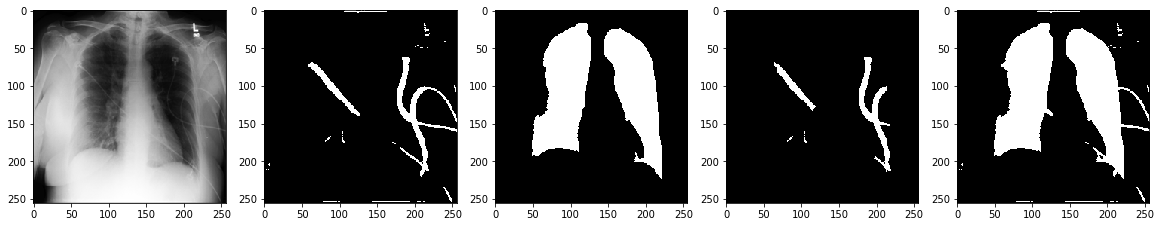

In [347]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20,20))
print(f"Drain Label: {y_test}")
axs[0].imshow(drain_image)
axs[1].imshow(drain_mask, cmap='gray')
axs[2].imshow(lung_mask, cmap='gray')
axs[3].imshow(drain_mask & lung_mask, cmap='gray')
axs[4].imshow(drain_mask | lung_mask, cmap='gray')

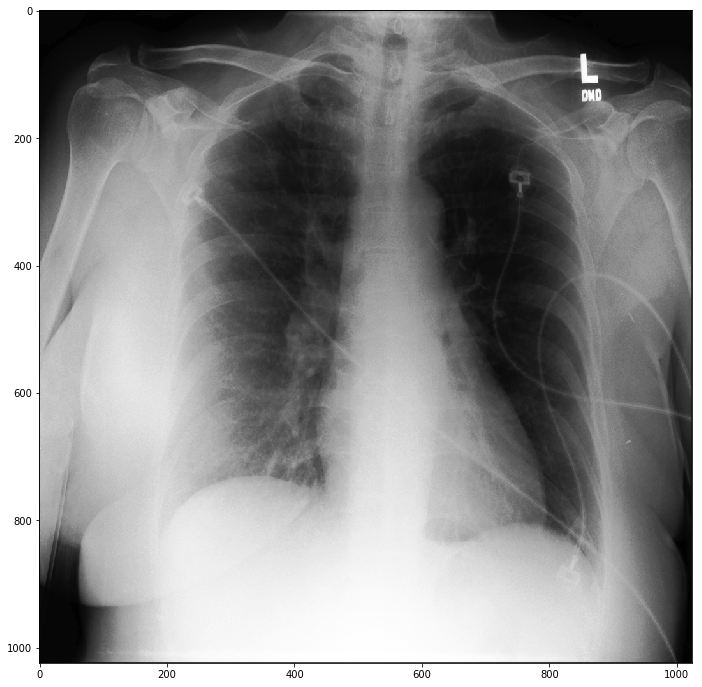

In [344]:
plt.figure(figsize=(12,12))
plt.imshow(x_test_data, cmap='gray')